In [1]:
import pandas as pd
import os
import re
import numpy as np
from collections import defaultdict
#from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
from scipy.cluster.hierarchy import dendrogram, linkage, ClusterWarning
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from warnings import simplefilter
simplefilter("ignore", ClusterWarning)

### Iteration 1 | Parse VCF files to table/dataframe

In [2]:
def read_vcf(file):
    with open(file, "r") as f:
        
        for line in f:   # Get header line
            if line.startswith('#CHROM'): hd = line; break
                
        hd = hd[1:].strip().split("\t")   # Remove # from CHROM and convert to list
        df = pd.read_csv(f, delimiter='\t', names=hd, comment='#')   # Save vcf as dataframe
    return df

In [3]:
#file = "/home/athena/Desktop/IiSGM-bioinfo-test/data/test.vcf"
file = "/home/athena/Desktop/IiSGM-bioinfo-test/data/10105494-0-COL2.combined.hf.SNP.final.vcf"
df = read_vcf(file)
df

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10105494-0-COL2
0,MTB_anc,1701,.,T,C,140323.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=0.814;DP=296;Ex...,GT:AD:DP:GQ:PL,"1/1:0,296:296:99:11020,884,0"
1,MTB_anc,2532,.,C,T,47660.33,PASS,AC=2;AF=1.00;AN=2;DP=109;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,109:109:99:3646,326,0"
2,MTB_anc,8040,.,G,A,88799.33,PASS,AC=2;AF=1.00;AN=2;DP=204;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,204:204:99:7045,612,0"
3,MTB_anc,9143,.,C,T,38105.33,PASS,AC=2;AF=1.00;AN=2;DP=87;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,87:87:99:3098,261,0"
4,MTB_anc,13460,.,G,A,33355.32,PASS,AC=2;AF=1.00;AN=2;DP=89;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,89:89:99:3127,266,0"
...,...,...,...,...,...,...,...,...,...,...
844,MTB_anc,4397324,.,G,C,22342.17,PASS,AC=2;AF=1.00;AN=2;DP=56;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,56:56:99:2155,168,0"
845,MTB_anc,4407588,.,C,T,45587.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=1.81;DP=108;Exc...,GT:AD:DP:GQ:PL,"1/1:0,108:108:99:3781,325,0"
846,MTB_anc,4408156,.,A,C,43801.33,PASS,AC=2;AF=1.00;AN=2;DP=88;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,88:88:99:3405,264,0"
847,MTB_anc,4408920,.,G,A,31138.27,PASS,AC=2;AF=1.00;AN=2;DP=76;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,76:76:99:1|1:4408920_G_A:3471,235,0:4408920"


### Iteration 2 | Extract relevant information from parsed VCF

Remove FILTER != PASS or end col indicating heterozigois (0/1, 1/2, ...)

In [4]:
def filter_vcf(df):
    df.drop(df[df.FILTER != "PASS"].index, inplace=True)   # Drop low quality sites
    for inf in df.itertuples():   # Drop "heterozygous"
        l_line = inf[-1]
        if l_line[0] != l_line[2]: df.drop(inf[0], inplace=True)   # If the alleles are not equal
    
    return df

In [5]:
filter_vcf(df)

,CHROM,POS,ID,REF,ALT,QUAL,FILTER,INFO,FORMAT,10105494-0-COL2
0,MTB_anc,1701,.,T,C,140323.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=0.814;DP=296;Ex...,GT:AD:DP:GQ:PL,"1/1:0,296:296:99:11020,884,0"
1,MTB_anc,2532,.,C,T,47660.33,PASS,AC=2;AF=1.00;AN=2;DP=109;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,109:109:99:3646,326,0"
2,MTB_anc,8040,.,G,A,88799.33,PASS,AC=2;AF=1.00;AN=2;DP=204;ExcessHet=3.0103;FS=0...,GT:AD:DP:GQ:PL,"1/1:0,204:204:99:7045,612,0"
3,MTB_anc,9143,.,C,T,38105.33,PASS,AC=2;AF=1.00;AN=2;DP=87;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,87:87:99:3098,261,0"
4,MTB_anc,13460,.,G,A,33355.32,PASS,AC=2;AF=1.00;AN=2;DP=89;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,89:89:99:3127,266,0"
...,...,...,...,...,...,...,...,...,...,...
844,MTB_anc,4397324,.,G,C,22342.17,PASS,AC=2;AF=1.00;AN=2;DP=56;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,56:56:99:2155,168,0"
845,MTB_anc,4407588,.,C,T,45587.33,PASS,AC=2;AF=1.00;AN=2;BaseQRankSum=1.81;DP=108;Exc...,GT:AD:DP:GQ:PL,"1/1:0,108:108:99:3781,325,0"
846,MTB_anc,4408156,.,A,C,43801.33,PASS,AC=2;AF=1.00;AN=2;DP=88;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PL,"1/1:0,88:88:99:3405,264,0"
847,MTB_anc,4408920,.,G,A,31138.27,PASS,AC=2;AF=1.00;AN=2;DP=76;ExcessHet=3.0103;FS=0....,GT:AD:DP:GQ:PGT:PID:PL:PS,"1|1:0,76:76:99:1|1:4408920_G_A:3471,235,0:4408920"


### Iteration 3 | Combine present SNP into a presence matrix

In [6]:
def presence_matrix(direct):
    dir_l = [direct + f for f in os.listdir(direct) if f.endswith(".vcf")] # Get vcf files in directory
    
    d = defaultdict(dict)
    for file in dir_l: # Read, filter, find mutations and create dict 
        df = read_vcf(file)
        filter_vcf(df)
        d = d_mut(df, d)
        
    pr_mat = pd.DataFrame(d).fillna(0).astype(int)   # 1/0 matrix
    
    return d, pr_mat
    #return pr_mat

In [7]:
def d_mut(df, d):
    """
    dict to store mutations. id of mutation as key1 organism as key2, 1 as value
    """
    org = df.columns[-1]   # Get sample id
    mut = list(df[["POS", "REF", "ALT"]].apply(lambda x: '_'.join(x.astype(str)), axis=1))   # Mutation id (POS_REF_ALT)
    for m in mut: d[m][org] = 1   # Dictionary for storing presence of mutations
    
    return d

In [8]:
direct = "/home/athena/Desktop/IiSGM-bioinfo-test/data/"
d, pr_mat = presence_matrix(direct)
#pr_mat = presence_matrix(direct)

In [9]:
pr_mat

,1701_T_C,2532_C_T,8040_G_A,9143_C_T,13460_G_A,14251_G_A,14401_G_A,15117_G_C,16055_C_A,17608_G_C,...,2470723_G_A,3665501_G_A,3909875_C_T,21819_C_A,684671_C_T,2719800_T_C,257448_C_T,2941477_T_C,"2074509_C_G,*",2468561_G_T
10105494-0-COL2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ALM23685B3COL7,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
ALM93896B2COL31,1,1,1,1,1,1,1,1,1,1,...,0,0,1,0,0,0,0,0,0,0
10105494-0-COL1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ALM93896B3COL2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
AL10105494COL0,1,1,1,1,1,1,1,1,1,1,...,0,0,0,1,1,1,0,0,0,0
10082989-0-COL2,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
ALM23685B3COL5,1,1,1,1,1,1,1,1,1,1,...,1,1,0,0,0,0,0,0,0,0
AL10082989COL3,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,1,1,0,0
ALM93896B3COL1,1,1,1,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0


In [10]:
# para ver cuántos snp hay
l=[]
for i in d.keys():
    l = l + list(d[i].keys())

# para ver las variantes alternativas
#for i in l:
#    if "," in i: print(i)
        
# inserciones
print("INSERCIONES")
for i in l:
    if re.match(".*_.+_..+", i):
        print(i)
        
# deleciones
print()
print("DELECIONES")
for i in l:
    if re.match(".*_..+_.+", i):
        print(i)

INSERCIONES

DELECIONES


### Iterations 4 and  6 | Calculate the SNP distance between all samples and Represent distance in a phylogenetic tree

In [11]:
def mut_dist(pr_mat, metric='jaccard'):
    np_mat = pr_mat.to_numpy()
    dist_mat = cdist(pr_mat, pr_mat, metric)
    dist_mat = pd.DataFrame(dist_mat, index=pr_mat.index, columns=pr_mat.index)
    
    return dist_mat, metric

In [12]:
def dendrog(dist_mat, metric):
    linkage_matrix = linkage(dist_mat)
    dendrogram(linkage_matrix, 
              orientation='left')
    plt.title("Distance dendrogram - " + metric)
    plt.show()
    return None

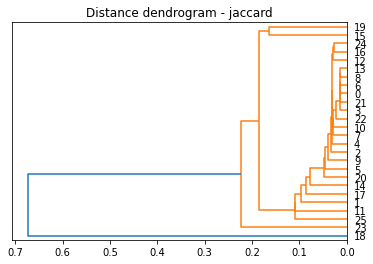

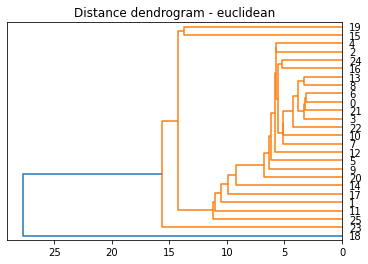

In [13]:
dist_mat_jaccard, metric = mut_dist(pr_mat)
dendrog(dist_mat_jaccard, metric)

dist_mat_eucl, metric = mut_dist(pr_mat, 'euclidean')
dendrog(dist_mat_eucl, metric)